In [2]:
from numpy import linalg as npl 
import scipy 
from scipy import interpolate
import numpy as np 
import matplotlib.pyplot as plt

def convol(a,b):
    return np.fft.ifftshift(np.fft.ifft(np.fft.fft(a)*np.fft.fft(b)))

def H(x, eps = 1e-7):
    return np.sqrt(x**2+eps**2)
def Hp(x,eps=1e-7):
    return x/np.sqrt(x**2+eps**2)

def convolution(pi, grid):
    n = pi.shape[0]
    n_padded = 2*n +1
    pi_padded = np.zeros(n_padded)
    pad = (n+1) // 2 
    pi_padded[pad:-pad] = pi
    S = grid[-1] + (grid[1]-grid[0])*(n_padded-n)/2.
    grid_padded = np.linspace(-S, S, n_padded)
    Hgrid=H(grid_padded)
    conv = convol(pi_padded, Hgrid)
    conv = conv[pad:-pad]
    return conv.real

def convolution_prime(pi, grid):
    n = pi.shape[0]
    n_padded = 2*n +1
    pi_padded = np.zeros(n_padded)
    pad = (n+1) // 2 
    pi_padded[pad:-pad] = pi
    S = grid[-1] + (grid[1]-grid[0])*(n_padded-n)/2.
    grid_padded = np.linspace(-S, S, n_padded)
#     Hgrid = Hp(grid_padded)
    Hgrid=Hp_modif(grid_padded)
    conv = convol(pi_padded, Hgrid)
    conv = conv[pad:-pad]
    return conv.real

def interp(grid, ky):
    return interpolate.interp1d(grid,ky, fill_value="extrapolate")

def F(p):
    N = len(p)  
    F = 0
    for i in range(N):
        for j in range(N):
            F += H(p[i]-p[j])
    return F/(2*N**2)

def gradF(p): 
    N = len(p)
    grad = np.zeros(N)
    for i in range(N):
#         grad[i] = np.sum(Hp(p[i]-p))
        grad[i] = np.sum(Hp_modif(p[i]-p))
    return grad/(N**2)

def G(p):
    ky = convolution(pi, grid)
    f = interp(grid,ky)
    return np.sum(f(p))/len(p)

def gradG(p):
    N = len(p)
    ky = convolution_prime(pi, grid)
    f = interp(grid,ky)
    grad = np.zeros(N)
    for i in range(N):
        grad[i] = np.sum(f(p[i]))
    return grad/len(p)

def J(p):
    return G(p) - F(p)

def gradJ(p):
    return gradG(p) - gradF(p)

def Gradient(J,gradJ,h=1e-1, pini = np.zeros(20)): 
    p = np.copy(pini)
    y = [p]
    eps = 1e-10
    itermax = 1000
    err = 2*eps
    iter = 0
    while err>eps and iter<itermax:
        p = p - h*gradJ(p)
        y.append(p)
        err = np.linalg.norm(gradJ(p))
        iter += 1
        if iter%100==0:
            plt.scatter(p,np.zeros_like(p))
            plt.show()
    xiter=np.array(y)
    return p,xiter,iter

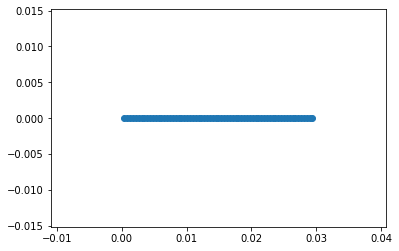

In [9]:
N = 67
grid = (np.arange(N)+0.5)/N - 0.5
# plt.scatter(grid, np.zeros(N))
#p = np.linspace(0,1,20)
# p = np.linspace(-0.2,0.2,20)
pi = np.arange(1,N+1)/N
pi/=np.sum(pi)
# print(pi)
plt.scatter(pi,np.zeros(N))
# plt.show()
# pmin, xiter, iter_ = Gradient(J,gradJ,pini=p)

In [3]:
print(pmin)

[-0.343837   -0.23145638 -0.15132427 -0.08608182 -0.02960531  0.02078682
  0.06681347  0.10942189  0.14930359  0.18682371  0.22248024  0.25644103
  0.2889524   0.3201963   0.35030499  0.37939294  0.40755976  0.43489246
  0.46144857  0.48727415]


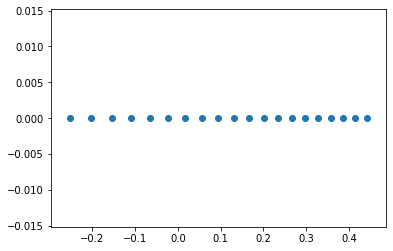

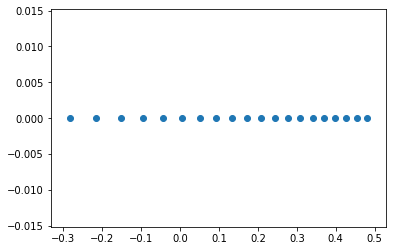

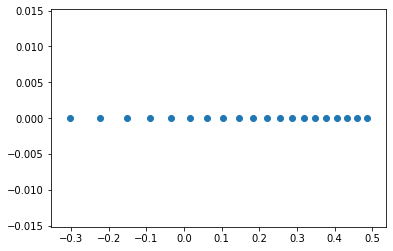

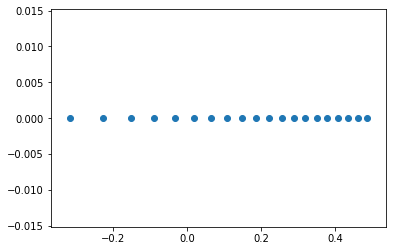

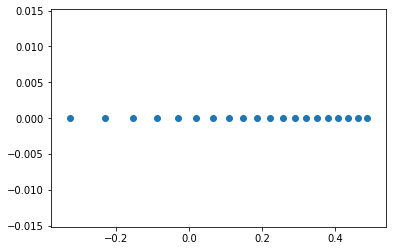

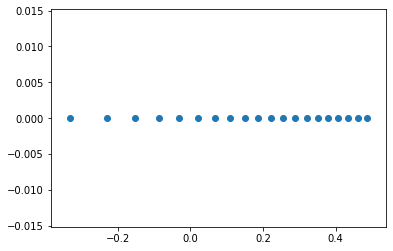

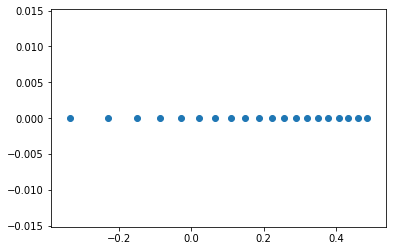

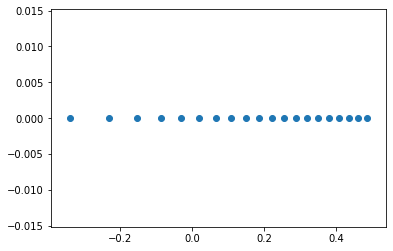

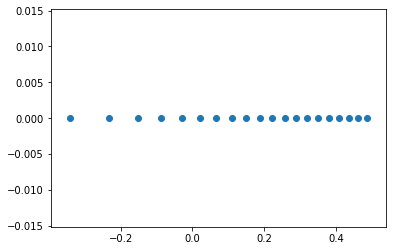

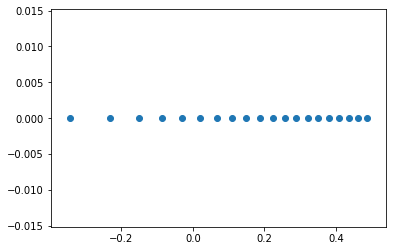

In [4]:
pi2 = np.zeros(20)
for i in range(20):
    pi2[i] = pi[i]**2 
pmin2, xiter2, iter2 = Gradient(J, gradJ, pini = p)


In [ ]:
def H(x, eps):
    return np.sqrt(npl.norm(x)**2+eps**2)
def gradH(x,eps):
    return x/np.sqrt(npl.norm(x)**2+eps**2)

def R(p, eps, comput_loss=True, compute_grad = True):
#     p(N,d)
    N = np.shape[0]
    p_k = LazyTensor(p[:,None,:])
    p_j = LazyTensor(p[None,:,:])
    grid = p_k - p_j 
    grad = torch.zeros_like(p)
    loss = torch.tensor(0)
    if compute_grad and compute_loss:
        norm = ((grid**2).sum(dim=2)+eps**2).sqrt()